In [1]:
using Plots
using Statistics
using Surrogates
using CSV
using DataFrames
using Flux
import JSON
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

include("../../scan_hyperparameters_emi4D_functions.jl")

Passed N Threads == N GPU sanity check!
Gathering arguments...


LoadError: LoadError: ArgParseError("too many arguments")
in expression starting at /Users/Josh/Desktop/research/rfq-nn/scan_hyperparameters_emi4D_functions.jl:353

### Loading data and making cuts for proper scaling

In [3]:
target_directory = "../../data/full_opt_15KeV/"

println("Formatting data...")
x_raw_df, y_df = getrawdata(target_directory)

# cutting
println("Cutting Transmission to 60-100 percent...")
lower::Float32 = 60
upper::Float32 = 120
x_raw_df, y_df = applycut(x_raw_df, y_df, "OBJ1", lower, upper)

# decorrelating
println("Decorrelating...")
x_df = decorrelatedvars(x_raw_df)

#= Replace OBJ5 and 6 with polar form
y_df = DataFrame(
    "OBJ1"=>y_df[:, "OBJ1"],
    "OBJ2"=>y_df[:, "OBJ2"],
    "OBJ3"=>y_df[:, "OBJ3"],
    "OBJ4"=>y_df[:, "OBJ4"],
    "OBJ5"=>(sqrt.(y_df[:, "OBJ5"].^2.0 .+ y_df[:, "OBJ6"].^2.0)),
    "OBJ6"=>(atan.(y_df[:, "OBJ6"], y_df[:, "OBJ5"])) 
) =#

# modify obj5 and obj6
emits = hcat(y_df[:, "OBJ5"], y_df[:, "OBJ6"]);

y_df = DataFrame(
    "OBJ1"=>y_df[:, "OBJ1"],
    "OBJ2"=>y_df[:, "OBJ2"],
    "OBJ3"=>y_df[:, "OBJ3"],
    "OBJ4"=>y_df[:, "OBJ4"],
    "OBJ5"=>[maximum(emit) for emit in eachrow(emits)],
    "OBJ6"=>[minimum(emit) for emit in eachrow(emits)],
)

x_scaled_df, x_scalers = minmaxscaledf(x_df);
y_scaled_df, y_scalers = minmaxscaledf(y_df);

println("Done!")

Formatting data...
Cutting Transmission to 60-100 percent...
x_raw shape: (217293, 14)
y_raw shape: (217293, 6)
x_new shape: (161574, 14)
y_new shape: (161574, 6)
Decorrelating...
Done!


### Loading up previously trained model

In [4]:
@load "../../models/2023-04-10_11-56-25_w=100_d=5_activation=sigmoid_bs=1024_lr=0.001_dr=0.0_1.jld2" m;

```
DVAR1: Bmax  [ 8.5, 12.0 ]
DVAR2: mX1  [ 5, 140 ]
DVAR3: mX2  [ 15, 160 ]
DVAR4: mY1  [ 1.005, 1.7 ]
DVAR5: mY2  [ 1.055, 1.85 ]
DVAR6: mtau1  [ 1, 500 ]
DVAR7: mtau2  [ 1, 500 ]
DVAR8: PhiY1  [ -89.95, -30 ]
DVAR9: PhiY2  [ -87.45, -25 ]
DVAR10: Phitau1  [ 1, 500 ]
DVAR11: Phitau2  [ 1, 500 ]
DVAR12: mY3ref  [ 1.105, 2.0 ]
DVAR13: PhiY3ref  [ -84.95, -20 ]
DVAR14: Eref  [ 0.055, 0.075 ]
```

### Sampling for init of acquisition function

In [5]:
# bounds of DVARS
lower_bound = repeat([-1.], 14); upper_bound = repeat([1.], 14)

# smapling to instantiate acquisition function
n_samples = 1000
initial_samples = Surrogates.sample(n_samples, lower_bound, upper_bound, SobolSample());

In [6]:
# decorrelating design variables
function getdvarprimesing(data_to_transform, dynamic_lower_bound, strict_upper_bound)
    (data_to_transform - dynamic_lower_bound) / (strict_upper_bound - dynamic_lower_bound)
end

function decorr(vec)
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )
    
    decorred_vec = []
    
    for i in 1:14
        if i == 3
            append!(decorred_vec, getdvarprimesing(vec[3], etas["DVAR3"] + vec[2], maxes["DVAR3"]))
        elseif i == 5
            append!(decorred_vec, getdvarprimesing(vec[5], etas["DVAR5"] + vec[4], maxes["DVAR5"]))
        elseif i == 9
            append!(decorred_vec, getdvarprimesing(vec[9], etas["DVAR9"] + vec[8], maxes["DVAR9"]))
        elseif i == 12
            append!(decorred_vec, getdvarprimesing(vec[12], etas["DVAR12"] + vec[5], maxes["DVAR12"]))
        elseif i == 13
            append!(decorred_vec, getdvarprimesing(vec[13], etas["DVAR13"] + vec[9], maxes["DVAR13"]))
        else
            append!(decorred_vec, vec[i])
        end
    end
    
    decorred_vec
end

function getvarsing(data_to_transform, dynamic_lower_bound, strict_upper_bound)
    dynamic_lower_bound + data_to_transform*(strict_upper_bound - dynamic_lower_bound)
end

function recorr(vec)
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )
    dvarmap = Dict(
        3=>2,
        5=>4,
        9=>8,
        12=>5,
        13=>9
    )
    
    recorred_vec = []
    
    for i in 1:14
        if i ∈ [3, 5, 9]
            append!(recorred_vec, getvarsing(vec[i], etas["DVAR$i"] + vec[dvarmap[i]], maxes["DVAR$i"]))
        elseif i ∈ [12, 13]
            append!(recorred_vec, getvarsing(vec[i], etas["DVAR$i"] + recorred_vec[dvarmap[i]], maxes["DVAR$i"]))
        else
            append!(recorred_vec, vec[i])
        end
    end
    
    recorred_vec
end

function minmaxscale(vec; var="x", inverse=false)
    scaled_vec = []
    
    transform_fun(scaler, x) = inverse ? inverse_transform(scaler, x) : transform(scaler, x)
    
    if var == "x"
        for i in 1:14
            scaler = x_scalers["DVAR$i"]
            append!(scaled_vec, transform_fun(scaler, vec[i]))
        end
    elseif var == "y"
        for i in 1:6
            scaler = y_scalers["OBJ$i"]
            append!(scaled_vec, transform_fun(scaler, vec[i]))
        end
    end
    
    return Tuple(scaled_vec)
end

function predict(x_vec)
    m([x for x in x_vec])'
end

predict (generic function with 1 method)

### Minimize emittance

In [7]:
function objective(x_vec)
    predict(x_vec)[5]
end

objective (generic function with 1 method)

In [8]:
# samples to instantiate acquisition function
xs = [sample for sample in initial_samples]
xs = unique(xs)
ys = objective.(xs);

In [9]:
# surrogate for acquisition function
kriging_surrogate = Kriging(xs, ys, lower_bound, upper_bound, p=repeat([1.9], 14))

(::Kriging{Vector{NTuple{14, Float64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64, Matrix{Float64}}) (generic function with 2 methods)

In [10]:
# the optimization
optimum = surrogate_optimize(
    objective, LCBS(), lower_bound, upper_bound, kriging_surrogate, SobolSample(), maxiters=500
)

Out of sampling points


((-0.294921875, 0.646484375, 0.333984375, 0.869140625, -0.267578125, 0.236328125, -0.330078125, -0.841796875, -0.919921875, -0.533203125, -0.158203125, 0.431640625, 0.337890625, 0.001953125), -1.0554024456579314)

### Maximize transmission, minimize emittance.

In [11]:
function objective2(x_vec)
    y = predict(x_vec)
    [-y[1], y[5]]
end

objective2 (generic function with 1 method)

In [12]:
x2s = [sample for sample in initial_samples];
x2s = unique(x2s)
y2s = objective2.(x2s);

In [13]:
println(length(x2s))
println(length(y2s))
if length(x2s) != length(unique(x2s))
    print("Duplicate entries in x2")
end
if length(x2s) != length(y2s)
    print("Dimension mismatch between x2 and y")
end
radial_basis_ego = RadialBasis(x2s, y2s, lower_bound, upper_bound)

1000
1000


(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{NTuple{14, Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64, Bool}) (generic function with 1 method)

In [14]:
pareto_set, pareto_front = surrogate_optimize(
    objective2, SMB(), lower_bound, upper_bound, radial_basis_ego, SobolSample();
    maxiters = 100, n_new_look = 100
);

In [15]:
pareto_front

16-element Vector{Any}:
 [-0.8396873197236295, -0.6795768461677891]
 [0.6480605326687222, -0.9152154770065499]
 [-0.8063016624285139, -0.767749217573348]
 [-0.9758630484149978, -0.48722809730894573]
 [1.0294251535162648, -1.0554024456579314]
 [0.09757574324446286, -0.898369042498101]
 [-0.37495762673700594, -0.8305515362002414]
 [-0.32944077967424984, -0.8567375031486737]
 [0.9124888696267727, -0.9268261466780641]
 [-0.9431107909901867, -0.5871693049495221]
 [-0.9526317500274281, -0.552892119583789]
 [-0.0216365067173129, -0.8576998558687293]
 [-0.4522163290233413, -0.8150082713636072]
 [-0.8160355937256967, -0.743192480242534]
 [-0.5583861489618449, -0.7832775547251787]
 [0.9478578342889223, -1.055339164475894]

In [16]:
obj1 = [inverse_transform(y_scalers["OBJ1"], -item[1])[1] for item in pareto_front]
obj5 = [inverse_transform(y_scalers["OBJ5"], item[2])[1] for item in pareto_front]

16-element Vector{Float64}:
 0.042927353746839446
 0.03204540583666572
 0.03885549528570144
 0.051810146259334035
 0.02557147885313414
 0.03282338533069247
 0.035955242650964225
 0.034745957368257946
 0.03150921742766879
 0.04719479515262699
 0.04877773825635139
 0.03470151528279181
 0.03667304090715094
 0.03998954166649454
 0.038138386399877613
 0.025574401219998072

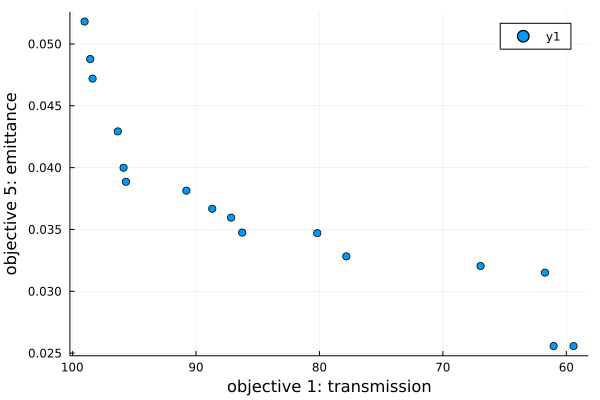

In [17]:
scatter(obj1, obj5; xlabel="objective 1: transmission", ylabel="objective 5: emittance")
xflip!(true)

### Final optimization
- Maximize transmission (< 95%)
- Output energy should be 70 KeV (0.070 MeV)
- Minimize RFQ length
- Minimize longitudinal emittance
- Minimize transverse emittance

In [7]:
function objective3(x_vec)
    y = predict(x_vec)
    target_energy_scaled = transform(y_scalers["OBJ2"], 0.070)[1]
    [-y[1], (y[2] - target_energy_scaled)^2, y[3], y[4], y[5], y[6]]
end

objective3 (generic function with 1 method)

In [8]:
x3s = [sample for sample in initial_samples];
x3s = unique(x3s)
y3s = objective3.(x3s);

In [9]:
if length(x3s) != length(unique(x3s))
    print("Duplicate entries in x3")
end
if length(x3s) != length(y3s)
    print("Dimension mismatch between x3 and y")
end
radial_basis_ego_3 = RadialBasis(x3s, y3s, lower_bound, upper_bound)

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{NTuple{14, Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64, Bool}) (generic function with 1 method)

In [10]:
pareto_set_3, pareto_front_3 = surrogate_optimize(
    objective3, SMB(), lower_bound, upper_bound, radial_basis_ego_3, SobolSample();
    maxiters = 100, n_new_look = 100
);

In [15]:
obj1_3 = [inverse_transform(y_scalers["OBJ1"], -item[1])[1] for item in pareto_front_3];
dE_3 = [item[2] for item in pareto_front_3];
obj3_3 = [inverse_transform(y_scalers["OBJ3"], item[3])[1] for item in pareto_front_3];
obj4_3 = [inverse_transform(y_scalers["OBJ4"], item[4])[1] for item in pareto_front_3];
obj5_3 = [inverse_transform(y_scalers["OBJ5"], item[5])[1] for item in pareto_front_3];
obj6_3 = [inverse_transform(y_scalers["OBJ6"], item[6])[1] for item in pareto_front_3];

unscaled_pareto_front_3 = [obj1_3, dE_3, obj3_3, obj4_3, obj5_3, obj6_3]

6-element Vector{Vector{Float64}}:
 [92.62628290090527, 63.07773852951512, 53.788307526625175, 95.95826096796748, 80.79769651294059, 78.14406468398832, 68.23247215435386, 61.32276542849349, 55.96844161304543, 72.6636445793578  …  70.57095990927778, 56.885030455928586, 57.10371327651937, 54.562635659705236, 85.08884895732804, 58.19650078933194, 53.813747069518975, 59.67035282622424, 63.515437343590484, 70.81588724537482]
 [0.0036360375853054954, 0.3268188907443441, 0.0004950586767723036, 0.01319153515838029, 0.16246618764856968, 0.020528466695318028, 0.06972641511321026, 0.0001248589104607662, 0.013638782251654146, 0.013744614915107561  …  0.3836166457962696, 0.07812157335080128, 0.04594174574982605, 0.15659138281783544, 0.213617573415125, 0.06987804225162081, 0.23356249705778098, 0.005006226233290857, 0.007894134214443366, 0.4532465223271124]
 [166.89533645846177, 51.48015657039094, 121.24748684535668, 173.5288171954873, 88.93462044297489, 142.30766826502077, 129.75813273824014, 132.95

In [16]:
emit_cutoff = 0.04
long_emit_mask = obj4_3 .< emit_cutoff; trans_emit_mask = obj5_3 .< emit_cutoff;


transmission_cutoff = 90
high_transmission_mask = obj1_3 .> 90

sum(long_emit_mask .& trans_emit_mask .& high_transmission_mask)

8

In [17]:
candidates = [i for i in 1:length(obj1_3)][long_emit_mask .& trans_emit_mask .& high_transmission_mask]

8-element Vector{Int64}:
 111
 173
 188
 253
 301
 326
 427
 459

In [19]:
for j in candidates
    println("candidate $j")
    candidate_dvars = minmaxscale(pareto_set_3[j]; var="x", inverse=true)
    println(recorr(candidate_dvars))
    for i in 1:6
        println("OBJ$i: ", unscaled_pareto_front_3[i][j])
    end
    println(" ")
end

candidate 111
Any[11.312970323488116, 103.74379387497902, 149.3844632942009, 1.4468444964149967, 1.5137434508318173, 140.85678306221962, 473.19513192772865, -50.198363710194826, -43.642042370082365, 245.1396758556366, 245.14222127199173, 1.8956221811010057, -37.69371108684824, 0.06037109433236765]
OBJ1: 94.79876573842469
OBJ2: 0.17501622242697612
OBJ3: 193.25768612868725
OBJ4: 0.03858259125407443
OBJ5: 0.0341736188594608
OBJ6: 0.026246556505827648
 
candidate 173
Any[9.14601474441588, 64.9847204387188, 76.2309561819387, 1.5052128004608676, 1.7909850165139312, 159.3742377460003, 287.0468702018261, -49.37874272093177, -44.20807974211494, 446.882483959198, 415.69541972875595, 1.9007708828235987, -38.63379833969139, 0.07181640870840056]
OBJ1: 94.58276360004898
OBJ2: 0.06372045925088275
OBJ3: 147.07616211377461
OBJ4: 0.03351893707102554
OBJ5: 0.027653176211403615
OBJ6: 0.02315885975402657
 
candidate 188
Any[9.638193929567933, 92.40610572695732, 132.9467267730292, 1.3640429488150403, 1.5106

Clearly, `138` is the winner.

In [41]:
candidate_dvars[[1, 2, 3]]

(9.14601474441588, 64.9847204387188, 0.014658961890745559)

In [121]:
function plot_pairwise_scatter(vec1, vec2, vec1label, vec2label, indexes, winner_index, incl_xticks, incl_yticks)
    loser_indexes = [i for i in indexes if i != winner_index]
    
    
    scatter(
        [vec1[i] for i in loser_indexes], [vec2[i] for i in loser_indexes];
        xlabel=vec1label, ylabel=vec2label, legend=false, markersize=3, markerstrokewidth=0.5,
        xformatter = incl_xticks ? :auto : Returns(""), yformatter = incl_yticks ? :auto : Returns("") 
    )
    
    scatter!([vec1[winner_index]], [vec2[winner_index]]; markershape=:star5, markersize=10, markerstrokewidth=0.5)
end

plot_pairwise_scatter (generic function with 3 methods)

In [124]:
labels = [
    "Transmission [%]",
    "Scaled target/output\nenergy squared error",
    "RFQ length [cm]",
    "Longitudinal emittance\n[MeV deg]",
    "Transverse (radial)\nemittance [cm mrad]"
]
indexes = [i for i in 1:length(pareto_front_3)]

layout = @layout([ ° _ _ _ ; ° ° _ _ ; ° ° ° _ ; ° ° ° ° ])

#plot(p1, p2, p3, layout = l)

plots_dict = Dict()

for i in 1:5
    for j in 1:5
        if i < j
            p = plot_pairwise_scatter(
                unscaled_pareto_front_3[i], unscaled_pareto_front_3[j],
                j==5 ? labels[i] : "", i==1 ? labels[j] : "", indexes, 138, j==5, i==1
            )
            if i == 1
                xflip!(true)
            end
            # display(p)
            merge!(plots_dict, Dict("$i$j"=>p))
        end
    end
end

pareto_plot = plot(
    [plots_dict["$i$j"] for j in 1:5 for i in 1:5 if i<j]...,
    layout = layout, widths=(1/4,1/4,1/4,1/4), size=(1000,800), dpi=500
)

# savefig(pareto_plot,"../../img/pareto_plot.png")

## CHECKING OPTIMAL ANSWER FROM ABOVE

In [30]:
optimal_dvars = [
    9.14601474441588,
    64.9847204387188,
    76.2309561819387,
    1.5052128004608676,
    1.7909850165139312,
    159.3742377460003,
    287.0468702018261,
    -49.37874272093177,
    -44.20807974211494,
    446.882483959198,
    415.69541972875595,
    1.9007708828235987,
    -38.63379833969139,
    0.07181640870840056,
]

optimal_dvars_decorr = decorr(optimal_dvars);
optimal_dvars_decorred_scaled = minmaxscale(optimal_dvars_decorr);
optimal_predicted_objs_scaled = predict(optimal_dvars_decorred_scaled);
optimal_predicted_objs = minmaxscale(optimal_predicted_objs_scaled; var="y", inverse=true)

(95.67445783296316, 0.06584600251118666, 147.91082243803984, 0.035490431684761965, 0.03885549528570143, 0.77829399178314)